<a href="https://colab.research.google.com/github/yerin85/National-Petition-Category-classification/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 기본 설정**



In [ ]:

from google.colab import drive 

drive.mount('/content/gdrive/')

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 11.8MB/s 
     |████████████████████████████████| 460kB 59.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tqdm import tqdm

# **2. 데이터 불러오기**

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/TLO/train_dataset.csv', encoding = 'utf-8')
test = pd.read_excel('/content/gdrive/My Drive/TLO/webcrawling_data.xlsx')

In [ ]:
train

,category,content
0,육아/교육,"안녕하세요. 현재 사대, 교대 등 교원양성학교들의 예비교사들이 임용절벽에 매우 힘들..."
1,육아/교육,대통령님^^ 민주주의 사회에서는 국공립과 사립은 공존하여 서로 경쟁 발전해야하며 시...
2,인권/성평등,기간제 교사 쪼개기 계약 시정 부탁드립니다. 현재 많은 기간제 선생님들이 1년 계약...
3,안전/환경,안녕하세요. 초등학교 아이를 둔 주부입니다. GMO에 대해서 저도 알게 된건 1년정...
4,육아/교육,"★★★ 민간,가정 모든 사립영유아교육기관의 나아갈길!!!★★★ 국민은 법 앞에 평등..."
...,...,...
146715,기타,범죄자와 주인의 주종관계(고용주와 고용인)를 뒤집어 판결을 선고한 재판에 관여한 대...
146716,정치개혁,"국회의원님들 ""인사청문회""를 거쳐서 총선출마 하도록 국민청원법을 제정하면 좋을듯 합..."
146717,기타,문재인 대통령님께 청원합니다. 저는 딸 아이를 둔 사십대 가장입니다. 촛불시민의 일...
146718,외교/통일/국방,백의민족 한겨레의 국민염원 남북통일 두려움에 벌벌떠는 쪽섬왜구 검은속내 우리들의 참...


In [ ]:
test

,category,title,contents
0,정치개혁,커밍아웃검사 사표 받으십시오!,커밍아웃검사 사표 받으십시오!!!!\n\n정치인 총장이 검찰을 정치로 덮어 망치고 ...
1,육아/교육,"울산 동구에서 발생한 끔찍한 어린이집 학대 사건, 가해교사는 원장의 딸",저희는 울산 동구에 살고 있는 6세 남자아이의 부모입니다.\n저희 아이는 작년 5세...
2,기타,2019.06.30. 발생된 가평 익사사건의 진실을 밝혀주세요,[ 2019.06.30. 발생된 가평 익사사건의 진실을 밝혀주세요 ]\n\n안녕하세...
3,정치개혁,정경심 교수님은 무죄입니다.,오늘 서울중앙지법 형사합의 25-2부\n(부장판사 임정엽.권성수. 김선희)심리로 열...
4,정치개혁,"라임, 옵티머스 사태 특별검사 도입하라!!","라임사태, 옵티머스 사태는\n전국민을 대상으로 수조원의 사기를 벌인\n초대형 사기극..."
...,...,...,...
547,행정,국정철학에 맞게 공정한 체육관 운영대책을 세워주세요.,20-10-30 ~ 20-11-29\n\n\n\n\n\n촛불혁명을 위해 촛불을 들었...
548,기타,제주도 미등기 농가주택 임차인 미보호에 관한 보고,'안녕하세요. 시청 뒷쪽에서 소바가게 하고 있습니다.'\n\n 우려 했던 것보다 첫...
549,일자리,"지방할달, 지역인재 50%까지 확대, 다시한번 생각해 주십시오.",30일 이낙연 민주당 대표는 지방할당을 50%까지 늘리는 방안을 검토중이라고 발표하...
550,안전/환경,동대문구 전농동 배봉산둘레길 계단불편문의 (배봉초등학교 후문쪽)와 공원시설마련 건의내,서울 동대문구 배봉초등학교 후문쪽에 있는 배봉산 올라가는 길은 매우 가파른 200...


# **3. 데이터 전처리 과정**

(1) 불용화 제거, 기타 카테고리 제거

In [ ]:
test = test.dropna(axis=0)

#카테고리가 기타인 값 제거
#index_num = test[test['category']=='기타'].index
#test = test.drop(index_num)
#print(test)
test
train = train.dropna(axis=0)

#카테고리가 기타인 값 제거
#index_num = train[train['category']=='기타'].index
#train = train.drop(index_num)

#print(train)

(2) 카테고리 인덱싱

In [ ]:
train.loc[train["category"] == "정치개혁","category"] = 0
train.loc[train["category"] == "외교/통일/국방","category"] = 1
train.loc[train["category"] == "일자리","category"] = 2
train.loc[train["category"] == "미래","category"] = 3
train.loc[train["category"] == "성장동력","category"] = 4
train.loc[train["category"] == "농산어촌","category"] = 5
train.loc[train["category"] == "보건복지","category"] = 6
train.loc[train["category"] == "육아/교육","category"] = 7
train.loc[train["category"] == "안전/환경","category"] = 8
train.loc[train["category"] == "저출산/고령화대책","category"] = 9
train.loc[train["category"] == "행정","category"] = 10
train.loc[train["category"] == "반려동물","category"] = 11
train.loc[train["category"] == "교통/건축/국토","category"] = 12
train.loc[train["category"] == "경제민주화","category"] = 13
train.loc[train["category"] == "인권/성평등","category"] = 14
train.loc[train["category"] == "문화/예술/체육/언론","category"] = 15
train.loc[train["category"] == "기타","category"] = 16

test.loc[test["category"] == "정치개혁","category"] = 0
test.loc[test["category"] == "외교/통일/국방","category"] = 1
test.loc[test["category"] == "일자리","category"] = 2
test.loc[test["category"] == "미래","category"] = 3
test.loc[test["category"] == "성장동력","category"] = 4
test.loc[test["category"] == "농산어촌","category"] = 5
test.loc[test["category"] == "보건복지","category"] = 6
test.loc[test["category"] == "육아/교육","category"] = 7
test.loc[test["category"] == "안전/환경","category"] = 8
test.loc[test["category"] == "저출산/고령화대책","category"] = 9
test.loc[test["category"] == "행정","category"] = 10
test.loc[test["category"] == "반려동물","category"] = 11
test.loc[test["category"] == "교통/건축/국토","category"] = 12
test.loc[test["category"] == "경제민주화","category"] = 13
test.loc[test["category"] == "인권/성평등","category"] = 14
test.loc[test["category"] == "문화/예술/체육/언론","category"] = 15
train.loc[train["category"] == "기타","category"] = 16

In [ ]:
train

,category,content
0,7,"안녕하세요. 현재 사대, 교대 등 교원양성학교들의 예비교사들이 임용절벽에 매우 힘들..."
1,7,대통령님^^ 민주주의 사회에서는 국공립과 사립은 공존하여 서로 경쟁 발전해야하며 시...
2,14,기간제 교사 쪼개기 계약 시정 부탁드립니다. 현재 많은 기간제 선생님들이 1년 계약...
3,8,안녕하세요. 초등학교 아이를 둔 주부입니다. GMO에 대해서 저도 알게 된건 1년정...
4,7,"★★★ 민간,가정 모든 사립영유아교육기관의 나아갈길!!!★★★ 국민은 법 앞에 평등..."
...,...,...
146715,16,범죄자와 주인의 주종관계(고용주와 고용인)를 뒤집어 판결을 선고한 재판에 관여한 대...
146716,0,"국회의원님들 ""인사청문회""를 거쳐서 총선출마 하도록 국민청원법을 제정하면 좋을듯 합..."
146717,16,문재인 대통령님께 청원합니다. 저는 딸 아이를 둔 사십대 가장입니다. 촛불시민의 일...
146718,1,백의민족 한겨레의 국민염원 남북통일 두려움에 벌벌떠는 쪽섬왜구 검은속내 우리들의 참...


In [ ]:

test


,category,title,contents
0,0,커밍아웃검사 사표 받으십시오!,커밍아웃검사 사표 받으십시오!!!!\n\n정치인 총장이 검찰을 정치로 덮어 망치고 ...
1,7,"울산 동구에서 발생한 끔찍한 어린이집 학대 사건, 가해교사는 원장의 딸",저희는 울산 동구에 살고 있는 6세 남자아이의 부모입니다.\n저희 아이는 작년 5세...
2,기타,2019.06.30. 발생된 가평 익사사건의 진실을 밝혀주세요,[ 2019.06.30. 발생된 가평 익사사건의 진실을 밝혀주세요 ]\n\n안녕하세...
3,0,정경심 교수님은 무죄입니다.,오늘 서울중앙지법 형사합의 25-2부\n(부장판사 임정엽.권성수. 김선희)심리로 열...
4,0,"라임, 옵티머스 사태 특별검사 도입하라!!","라임사태, 옵티머스 사태는\n전국민을 대상으로 수조원의 사기를 벌인\n초대형 사기극..."
...,...,...,...
547,10,국정철학에 맞게 공정한 체육관 운영대책을 세워주세요.,20-10-30 ~ 20-11-29\n\n\n\n\n\n촛불혁명을 위해 촛불을 들었...
548,기타,제주도 미등기 농가주택 임차인 미보호에 관한 보고,'안녕하세요. 시청 뒷쪽에서 소바가게 하고 있습니다.'\n\n 우려 했던 것보다 첫...
549,2,"지방할달, 지역인재 50%까지 확대, 다시한번 생각해 주십시오.",30일 이낙연 민주당 대표는 지방할당을 50%까지 늘리는 방안을 검토중이라고 발표하...
550,8,동대문구 전농동 배봉산둘레길 계단불편문의 (배봉초등학교 후문쪽)와 공원시설마련 건의내,서울 동대문구 배봉초등학교 후문쪽에 있는 배봉산 올라가는 길은 매우 가파른 200...


(3)

In [ ]:
train_content = train['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
okt = Okt()

stopwords = ['있다','하다','을','를','이','가','의','은','들','좀','는','과','와','한','에','으로']

In [ ]:
#데이터 토큰화 (시간 좀 걸러요)
X_train=[]
for sentence in tqdm(train_content) : 
    temp_X = []
    temp_X = okt.morphs(sentence, stem = True)
    temp_X = [word for word in temp_X if not word in stopwords] #불용어제거
    temp_X = [word for word in temp_X if len(word) > 1 ] #토큰화하여 길이가 2 이상인 단어만 남기기
    X_train.append(temp_X)

100%|██████████| 146610/146610 [2:16:32<00:00, 17.89it/s]


In [ ]:
X_train[:1]

[['안녕하다',
  '현재',
  '사대',
  '교대',
  '교원양성',
  '학교',
  '예비교',
  '사들이다',
  '임용',
  '절벽',
  '매우',
  '힘들다',
  '압니',
  '정부',
  '부처',
  '에서는',
  '영양사',
  '교사',
  '폭발',
  '영양',
  '교사',
  '채용',
  '기간',
  '교사',
  '전강',
  '스강',
  '무기계약직',
  '화가',
  '임용',
  '절벽',
  '과는',
  '전혀',
  '무관',
  '일이',
  '라고',
  '주장',
  '하고',
  '조금',
  '생각',
  '해보다',
  '전혀',
  '설득',
  '없다',
  '이라고',
  '생각',
  '학교',
  '수가',
  '같다',
  '학생',
  '수가',
  '동일하다',
  '교사',
  '기간',
  '교사',
  '전강',
  '스강',
  '학교',
  '늘어나다',
  '되다',
  '당연하다',
  '정규',
  '교원',
  '줄어들다',
  '되다',
  '않다',
  '기간',
  '교사',
  '전강',
  '스강',
  '무기계약직',
  '정규직',
  '전면',
  '백지',
  '해주다',
  '년대',
  '국가',
  '교육',
  '달리다',
  '문제',
  '이다',
  '단순하다',
  '대통령',
  '일자리',
  '공약',
  '일자리',
  '추다',
  '공약',
  '지키다',
  '돌이키다',
  '없다',
  '실수',
  '않다',
  '바라다',
  '세계',
  '어느',
  '나라',
  '비교',
  '한국',
  '교원',
  '수준',
  '최고',
  '수준',
  '이다',
  '고등교육',
  '받다',
  '어렵다',
  '국가',
  '고시',
  '통과',
  '대한민국',
  '공립',
  '학교',
  '교단',
  '이러하다',
  '과정',
  '힘들다',
  '기다',
  '하지만',
  '교원',
 

In [ ]:
import numpy as np

np.save('X_train_data1',X_train)

In [ ]:
ls

'모델링1112의 사본'   model128_ep15.h5   model32_ep100.h5   X_train_data1.npy
'모델링1116의 사본'   model128_ep20.h5   model32_ep15.h5    X_train_data.npy
'Colab Notebooks'/    model16_ep15.h5    modeltest.h5
 IncheonSmartcity/    model1_ep15.h5     TLO@


In [ ]:
X_train = np.load('/content/gdrive/MyDrive/X_train_data1.npy', allow_pickle=True)

In [ ]:
X_train[:1]

array([list(['안녕하다', '현재', '사대', '교대', '교원양성', '학교', '예비교', '사들이다', '임용', '절벽', '매우', '힘들다', '압니', '정부', '부처', '에서는', '영양사', '교사', '폭발', '영양', '교사', '채용', '기간', '교사', '전강', '스강', '무기계약직', '화가', '임용', '절벽', '과는', '전혀', '무관', '일이', '라고', '주장', '하고', '조금', '생각', '해보다', '전혀', '설득', '없다', '이라고', '생각', '학교', '수가', '같다', '학생', '수가', '동일하다', '교사', '기간', '교사', '전강', '스강', '학교', '늘어나다', '되다', '당연하다', '정규', '교원', '줄어들다', '되다', '않다', '기간', '교사', '전강', '스강', '무기계약직', '정규직', '전면', '백지', '해주다', '년대', '국가', '교육', '달리다', '문제', '이다', '단순하다', '대통령', '일자리', '공약', '일자리', '추다', '공약', '지키다', '돌이키다', '없다', '실수', '않다', '바라다', '세계', '어느', '나라', '비교', '한국', '교원', '수준', '최고', '수준', '이다', '고등교육', '받다', '어렵다', '국가', '고시', '통과', '대한민국', '공립', '학교', '교단', '이러하다', '과정', '힘들다', '기다', '하지만', '교원', '교육자', '로서', '명감', '자부심', '갖다', '교육', '되다', '원동력', '이기도', '자격', '없다', '정규', '인력', '일자리', '늘리다', '명목', '학교', '들이다', '되다', '무슨', '대한민국', '공정하다', '사회', '라고', '아이', '에게', '가르치다', '가르치다', '학부모', '학생', '납득', '학생', '공부', '열심히', '이유',

In [ ]:
testdata = []
test_content = test['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
for sentence in tqdm(test_content):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords] #불용어제거
    temp_X = [word for word in temp_X if len(word) > 1 ] #토큰화하여 길이가 2 이상인 단어만 남기기
    testdata.append(temp_X)

100%|██████████| 490/490 [01:00<00:00,  8.05it/s]


In [ ]:
testdata[:1]

[['커밍아웃',
  '검사',
  '사표',
  '받다',
  '정치인',
  '총장',
  '검찰',
  '정치',
  '덮다',
  '망치',
  '반성',
  '하고',
  '자숙해',
  '모자라다',
  '정치검찰',
  '이제',
  '대놓고',
  '정치',
  '시작',
  '감찰',
  '전방',
  '문해',
  '정치',
  '하고',
  '추종',
  '정치검찰',
  '언론',
  '이용',
  '오히려',
  '검찰',
  '개혁',
  '방해',
  '하고',
  '자성',
  '목소리',
  '없이',
  '오히려',
  '정치인',
  '총장',
  '위해',
  '커밍아웃',
  '검사',
  '사표',
  '받다',
  '검찰',
  '개혁',
  '시작',
  '커밍아웃',
  '검사',
  '사표',
  '받다',
  '부터',
  '시작',
  '이다',
  '대한민국',
  '적폐',
  '청산',
  '출발',
  '검찰',
  '개혁',
  '가다']]

In [ ]:
vocab_size = 30000
tokenizer = Tokenizer(vocab_size) #가장 빈도가 높은 30000개의 단어만 선택하도록 Tokenizer 객체 생성
tokenizer.fit_on_texts(X_train) #단어 인덱스 구축

X_train = tokenizer.texts_to_sequences(X_train) #문자열을 정수 인덱스의 리스트로 변환
testdata = tokenizer.texts_to_sequences(testdata)

In [ ]:
max_len = 500 #데이터의 길이를 통일
X_train = pad_sequences(X_train, maxlen = max_len)
testdata = pad_sequences(testdata, maxlen = max_len)

In [ ]:
y_train = to_categorical(train['category'])

# **4. 모델링학습**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import load_model

# 기타포함

In [ ]:


tmodel32 = Sequential()
tmodel32.add(Embedding(vocab_size, 32, input_length=max_len)) 
#Embedding층은 전처리과정을 통해 입력된 값을 받아 다음층이 알아들을 수 있는 형태로 변환
#Embedding('불러온 단어의 개수','기사당 단어수')
tmodel32.add(LSTM(32))
#LSTM은 RNN에서 기억 값에 대한 가중치를 제어
#LSTM(기사당 단어수, 기타옵션)
tmodel32.add(Dense(16,  activation = 'softmax'))
tmodel32.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
tmodel32.summary()

In [ ]:
thistory_32 = tmodel32.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

plt.plot(thistory_32.history['acc'])
plt.plot(thistory_32.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(thistory_32.history['loss'])
plt.plot(thistory_32.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
tmodel32_ddd = Sequential()
tmodel32_ddd.add(Embedding(vocab_size, 32, input_length=max_len)) 
#Embedding층은 전처리과정을 통해 입력된 값을 받아 다음층이 알아들을 수 있는 형태로 변환
#Embedding('불러온 단어의 개수','기사당 단어수')
tmodel32_ddd.add(Dropout(0.2))
tmodel32_ddd.add(LSTM(32))
tmodel32_ddd.add(Dropout(0.2))
#LSTM은 RNN에서 기억 값에 대한 가중치를 제어
#LSTM(기사당 단어수, 기타옵션)
tmodel32_ddd.add(Dense(16,  activation = 'softmax'))
tmodel32_ddd.add(Dropout(0.2))
tmodel32_ddd.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
tmodel32_ddd.summary()

In [ ]:
thistory_32_ddd = tmodel32_ddd.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

In [ ]:

plt.plot(thistory_32_ddd.history['acc'])
plt.plot(thistory_32_ddd.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(thistory_32_ddd.history['loss'])
plt.plot(thistory_32_ddd.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

test_idx = test['category'].values


cnt_32 = 0
cnt_32ddd = 0

y_pred_32 = model32.predict_classes(testdata)
y_pred_32_ddd = model32_ddd.predict_classes(testdata)

for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_32[i]):
        cnt_32 = cnt_32 + 1


for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_32_ddd[i]):
        cnt_32ddd = cnt_32ddd + 1

print('layer32 일치율 : ', (cnt_32/len(y_pred_32))*100 )
print('layer32 일치율 : ', (cnt_32ddd/len(y_pred_32))*100 )

**(1) Layer16**

i) dropout 2개

In [ ]:
model16_2 = Sequential()
model16_2.add(Embedding(vocab_size, 16, input_length=max_len)) 
model16_2.add(LSTM(16))
model16_2.add(Dropout(0.2))
model16_2.add(Dense(16,  activation = 'softmax'))
model16_2.add(Dropout(0.2))
model16_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model16_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           480000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
Total params: 482,384
Trainable params: 482,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_16_2 = model16_2.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

Epoch 1/15
720/720 [==============================] - 24s 33ms/step - loss: 4.9096 - acc: 0.2308 - val_loss: 2.0587 - val_acc: 0.3555
Epoch 2/15
720/720 [==============================] - 23s 32ms/step - loss: 4.5646 - acc: 0.3598 - val_loss: 1.8685 - val_acc: 0.4162
Epoch 3/15
720/720 [==============================] - 23s 32ms/step - loss: 4.4607 - acc: 0.4215 - val_loss: 1.7850 - val_acc: 0.4658
Epoch 4/15
720/720 [==============================] - 23s 32ms/step - loss: 4.3427 - acc: 0.4589 - val_loss: 1.8319 - val_acc: 0.4533
Epoch 5/15
720/720 [==============================] - 23s 32ms/step - loss: 4.2900 - acc: 0.4836 - val_loss: 1.6891 - val_acc: 0.5160
Epoch 6/15
720/720 [==============================] - 23s 32ms/step - loss: 4.1819 - acc: 0.5155 - val_loss: 1.6753 - val_acc: 0.5175
Epoch 7/15
720/720 [==============================] - 23s 33ms/step - loss: 4.1476 - acc: 0.5304 - val_loss: 1.6717 - val_acc: 0.5298
Epoch 8/15
720/720 [==============================] - 24s 33ms

In [ ]:
model16_2.save('model16_2_ep15.h5')

In [ ]:
model = load_model('mnist_mlp_model.h5')

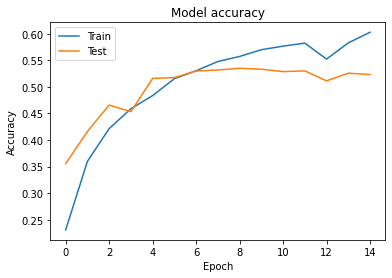

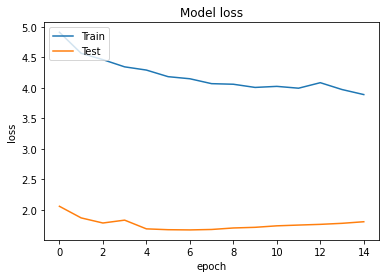

In [ ]:
#Layer(16)+D(2)
plt.plot(history_16_2.history['acc'])
plt.plot(history_16_2.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_16_2.history['loss'])
plt.plot(history_16_2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

ii) dropout 1개

In [ ]:
model16 = Sequential()
model16.add(Embedding(vocab_size, 16, input_length=max_len)) 
model16.add(LSTM(16))
model16.add(Dropout(0.2))
model16.add(Dense(16,  activation = 'softmax'))
model16.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           480000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
Total params: 482,384
Trainable params: 482,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_16 = model16.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

Epoch 1/15
720/720 [==============================] - 25s 34ms/step - loss: 2.2665 - acc: 0.2818 - val_loss: 2.0665 - val_acc: 0.3444
Epoch 2/15
720/720 [==============================] - 24s 33ms/step - loss: 1.9240 - acc: 0.3890 - val_loss: 1.9361 - val_acc: 0.3965
Epoch 3/15
720/720 [==============================] - 23s 33ms/step - loss: 1.7250 - acc: 0.4694 - val_loss: 1.8707 - val_acc: 0.4159
Epoch 4/15
720/720 [==============================] - 23s 33ms/step - loss: 1.5876 - acc: 0.5145 - val_loss: 1.7525 - val_acc: 0.4742
Epoch 5/15
720/720 [==============================] - 23s 32ms/step - loss: 1.4251 - acc: 0.5883 - val_loss: 1.6884 - val_acc: 0.5199
Epoch 6/15
720/720 [==============================] - 24s 33ms/step - loss: 1.3067 - acc: 0.6353 - val_loss: 1.6847 - val_acc: 0.5301
Epoch 7/15
720/720 [==============================] - 24s 33ms/step - loss: 1.2130 - acc: 0.6640 - val_loss: 1.6715 - val_acc: 0.5378
Epoch 8/15
720/720 [==============================] - 24s 33ms

In [ ]:
model16.save('model16_ep15.h5')

In [ ]:
model16 = load_model('/content/gdrive/MyDrive/model16_ep15.h5')

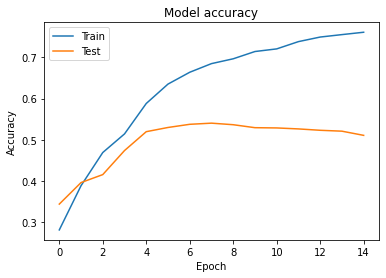

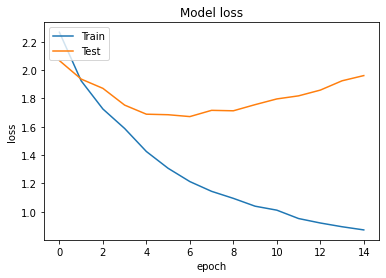

In [ ]:
#
plt.plot(history_16.history['acc'])
plt.plot(history_16.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_16.history['loss'])
plt.plot(history_16.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
model16_0 = Sequential()
model16_0.add(Embedding(vocab_size, 16, input_length=max_len)) 
model16_0.add(LSTM(16))
model16_0.add(Dense(16,  activation = 'softmax'))
model16_0.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model16_0.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 16)           480000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
Total params: 482,384
Trainable params: 482,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_16_0 = model16_0.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

Epoch 1/15
720/720 [==============================] - 24s 33ms/step - loss: 2.2699 - acc: 0.2542 - val_loss: 2.0571 - val_acc: 0.3367
Epoch 2/15
720/720 [==============================] - 23s 31ms/step - loss: 1.8207 - acc: 0.4457 - val_loss: 1.8863 - val_acc: 0.4295
Epoch 3/15
720/720 [==============================] - 23s 31ms/step - loss: 1.6054 - acc: 0.5337 - val_loss: 1.7845 - val_acc: 0.4819
Epoch 4/15
720/720 [==============================] - 23s 32ms/step - loss: 1.4552 - acc: 0.5819 - val_loss: 1.7541 - val_acc: 0.5045
Epoch 5/15
720/720 [==============================] - 23s 32ms/step - loss: 1.3525 - acc: 0.6145 - val_loss: 1.7310 - val_acc: 0.5136
Epoch 6/15
720/720 [==============================] - 23s 32ms/step - loss: 1.2675 - acc: 0.6447 - val_loss: 1.7225 - val_acc: 0.5189
Epoch 7/15
720/720 [==============================] - 23s 32ms/step - loss: 1.2024 - acc: 0.6644 - val_loss: 1.7336 - val_acc: 0.5138
Epoch 8/15
720/720 [==============================] - 23s 31ms

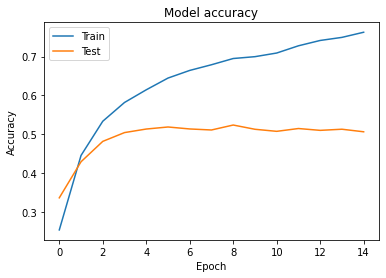

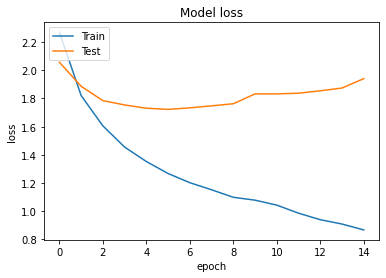

In [ ]:
#
plt.plot(history_16_0.history['acc'])
plt.plot(history_16_0.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_16_0.history['loss'])
plt.plot(history_16_0.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
test_idx = test['category'].values

In [ ]:
cnt_1 = 0
cnt_2 = 0
cnt_3 = 0

y_pred_16 = model16_0.predict_classes(testdata)
y_pred_16_d = model16.predict_classes(testdata)
y_pred_16_dd = model16_2.predict_classes(testdata)

for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_16_d[i]):
        cnt_1 = cnt_1 + 1
for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_16_dd[i]):
        cnt_2 = cnt_2 + 1
for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_16[i]):
        cnt_3 = cnt_3 + 1

print('Layer(16) 일치율 : ', (cnt_3/len(y_pred_16_d))*100 )
print('Layer(16)+D 1 일치율 : ', (cnt_1/len(y_pred_16_d))*100 )
print('Layer(16)+D 2 일치율 : ', (cnt_2/len(y_pred_16_d))*100 )

Layer(16) 일치율 :  50.816326530612244
Layer(16)+D 1 일치율 :  50.204081632653065
Layer(16)+D 2 일치율 :  51.83673469387755


(1) Layer 32 

In [ ]:


model32 = Sequential()
model32.add(Embedding(vocab_size, 32, input_length=max_len)) 
model32.add(LSTM(32))
model32.add(Dense(16,  activation = 'softmax'))
model32.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model32.summary()

history_32 = model32.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)           

In [ ]:
history_32 = model32.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

Epoch 1/15
720/720 [==============================] - 28s 39ms/step - loss: 2.1079 - acc: 0.3348 - val_loss: 1.8839 - val_acc: 0.4275
Epoch 2/15
720/720 [==============================] - 27s 37ms/step - loss: 1.6560 - acc: 0.5156 - val_loss: 1.7265 - val_acc: 0.4965
Epoch 3/15
720/720 [==============================] - 27s 37ms/step - loss: 1.4120 - acc: 0.5949 - val_loss: 1.7032 - val_acc: 0.5063
Epoch 4/15
720/720 [==============================] - 27s 37ms/step - loss: 1.3191 - acc: 0.6182 - val_loss: 1.6297 - val_acc: 0.5377
Epoch 5/15
720/720 [==============================] - 27s 37ms/step - loss: 1.2229 - acc: 0.6495 - val_loss: 1.6139 - val_acc: 0.5409
Epoch 6/15
720/720 [==============================] - 27s 37ms/step - loss: 1.1172 - acc: 0.6776 - val_loss: 1.6109 - val_acc: 0.5495
Epoch 7/15
720/720 [==============================] - 27s 37ms/step - loss: 1.0409 - acc: 0.6993 - val_loss: 1.6128 - val_acc: 0.5441
Epoch 8/15
720/720 [==============================] - 27s 37ms

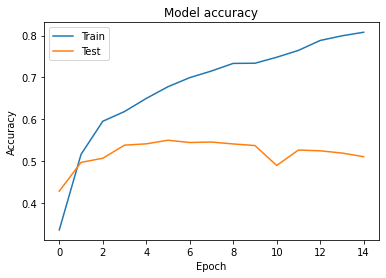

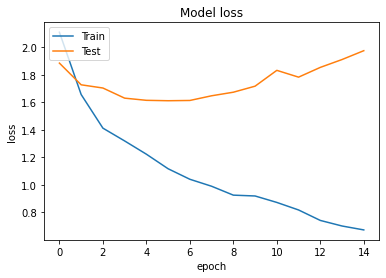

In [ ]:

plt.plot(history_32.history['acc'])
plt.plot(history_32.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_32.history['loss'])
plt.plot(history_32.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:

model32_ddd = Sequential()
model32_ddd.add(Embedding(vocab_size, 32, input_length=max_len)) 
model32_ddd.add(Dropout(0.2))
model32_ddd.add(LSTM(32))
model32_ddd.add(Dropout(0.2))
model32_ddd.add(Dense(16,  activation = 'softmax'))
model32_ddd.add(Dropout(0.2))
model32_ddd.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model32_ddd.summary()

history_32_ddd = model32_ddd.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           960000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
Total params: 968,848
Trainable params: 968,848
Non-trainable params: 0
________________________________________________

In [ ]:

history_32_ddd = model32_ddd.fit(X_train, y_train, batch_size=128, epochs=15, validation_split = 0.3)

Epoch 1/15
720/720 [==============================] - 28s 39ms/step - loss: 4.7537 - acc: 0.2952 - val_loss: 1.8797 - val_acc: 0.4163
Epoch 2/15
720/720 [==============================] - 28s 39ms/step - loss: 4.4059 - acc: 0.4322 - val_loss: 1.7250 - val_acc: 0.4896
Epoch 3/15
720/720 [==============================] - 28s 38ms/step - loss: 4.2864 - acc: 0.4750 - val_loss: 1.6563 - val_acc: 0.5209
Epoch 4/15
720/720 [==============================] - 28s 38ms/step - loss: 4.2371 - acc: 0.4964 - val_loss: 1.6339 - val_acc: 0.5261
Epoch 5/15
720/720 [==============================] - 28s 39ms/step - loss: 4.1897 - acc: 0.5147 - val_loss: 1.5990 - val_acc: 0.5441
Epoch 6/15
720/720 [==============================] - 28s 39ms/step - loss: 4.1197 - acc: 0.5351 - val_loss: 1.6021 - val_acc: 0.5486
Epoch 7/15
720/720 [==============================] - 28s 38ms/step - loss: 4.0955 - acc: 0.5456 - val_loss: 1.6152 - val_acc: 0.5461
Epoch 8/15
720/720 [==============================] - 28s 38ms

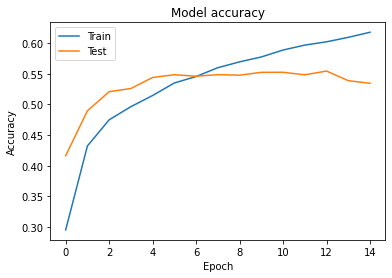

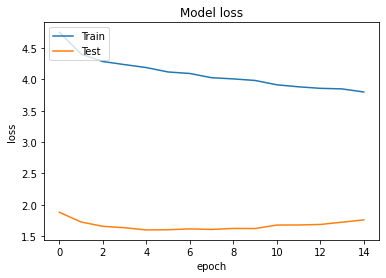

In [ ]:

plt.plot(history_32_ddd.history['acc'])
plt.plot(history_32_ddd.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_32_ddd.history['loss'])
plt.plot(history_32_ddd.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:


cnt_32 = 0
cnt_32ddd = 0

y_pred_32 = model32.predict_classes(testdata)
y_pred_32_ddd = model32_ddd.predict_classes(testdata)

for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_32[i]):
        cnt_32 = cnt_32 + 1


for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_32_ddd[i]):
        cnt_32ddd = cnt_32ddd + 1

print('layer32 일치율 : ', (cnt_32/len(y_pred_32))*100 )
print('layer32 일치율 : ', (cnt_32ddd/len(y_pred_32))*100 )

layer32 일치율 :  51.63265306122449
layer32 일치율 :  57.3469387755102


(2) Layer 128

In [ ]:
model128 = Sequential()
model128.add(Embedding(vocab_size, 128, input_length=max_len)) 
model128.add(LSTM(128))
model128.add(Dense(16, activation='softmax'))
model128.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])


In [ ]:
history_128 = model128.fit(X_train, y_train, batch_size=128, epochs=85, validation_split = 0.3)

In [ ]:
%cd '/content/gdrive/MyDrive'
model32.save('model32_ep100.h5')
model128.save('model128_ep20.h5')

/content/gdrive/MyDrive


In [ ]:
#model = load_model('model30.h5')

# **5. 결과**

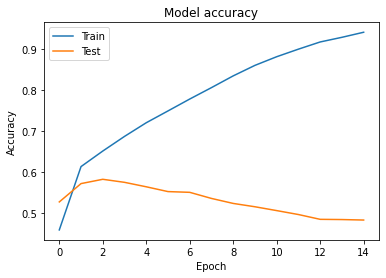

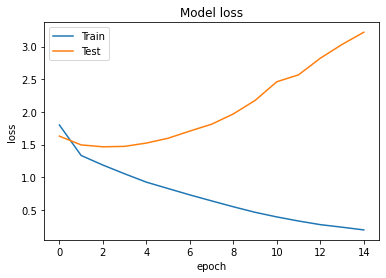

In [ ]:
plt.plot(history_128.history['acc'])
plt.plot(history_128.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_128.history['loss'])
plt.plot(history_128.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

cnt_128 = 0
y_pred_128 = model128.predict_classes(testdata)

for i in range(len(test_idx)):
    if(test_idx[i] == y_pred_128[i]):
        cnt_128 = cnt_128 + 1

print('layer128 일치율 : ', (cnt_128/len(y_pred_128))*100 )

In [ ]:
print('layer32 일치율 : ', (cnt_32/len(y_pred_32))*100 )
print('layer128 일치율 : ', (cnt_128/len(y_pred_128))*100 )

layer32 일치율 :  50.204081632653065
layer128 일치율 :  48.775510204081634
